In [2]:
import pandas as pd
link = "https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease"
path_1 = "/home/trancite/Desktop/Learning/AI for medical issues/Heart  disease/archive/2020/heart_2020_cleaned.csv"
path_2 = "/home/trancite/Desktop/Learning/AI for medical issues/Heart  disease/archive/2022/heart_2022_no_nans.csv.csv"
df = pd.read_csv(path_1)
df_negatives = df[df['HeartDisease'] == 'No']
df_positives = df[df['HeartDisease'] == 'Yes']

In this analysis we will work with a large dataset that includes health characteristics of individuals and a binary target indicating whether they have suffered from heart disease. Our approach will be to perform an exploratory analysis to better understand patterns in the data, followed by building a predictive model in a later installment.

Like always, the first thing we need to do is clean the data. It won’t be necessary to check for NAN (Not a Number) values because this dataset is already cleaned in that regard. However, we will check for any duplicate elements.

In [3]:
print(f'There are {len(df[df.duplicated()])} duplicated rows')


There are 18078 duplicated rows


Well, there are 18,078 duplicated rows. This could indicate two different situations: either there was an error during the data recording process and these values are corrupted, or these 18,078 individuals actually share every feature with at least one other individual. We will assume the latter case is true, as the sources of this dataset are reliable. Additionally, if we were to consider the first case, distinguishing between true duplicates and similar values would be challenging.

In [4]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


Okay, we have a brief understanding of how the dataset is structured. The first and most important step in a classification problem is to understand the distribution of the target class within the dataset. That's what we will do now.

There are 27373 instances with Heart Attack and the 292422 rest do not present it


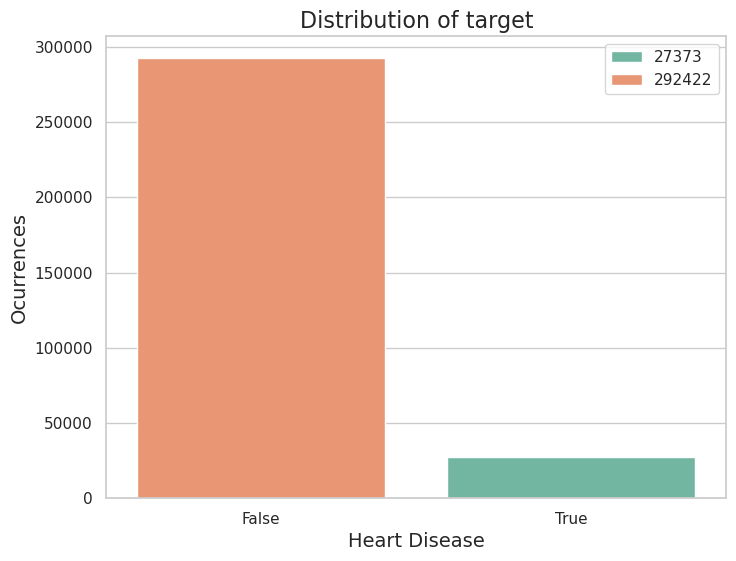

In [5]:
import numpy as np
Y = np.array(df['HeartDisease']) == 'Yes'
unique, counts = np.unique(Y, return_counts=True)
target_aparitions = dict(zip(unique, counts))
print(f'There are {target_aparitions[True]} instances with Heart Attack and the {target_aparitions[False]} rest do not present it')

import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.barplot(x=unique, y=counts, hue=counts, palette="Set2")

plt.title("Distribution of target", fontsize=16)
plt.xlabel("Heart Disease", fontsize=14)
plt.ylabel("Ocurrences", fontsize=14)

plt.show()


This is a clear example of an unbalanced dataset, where only 8% of the records belong to the positive class (presence of heart disease). This gives us a clue for our approach: we should avoid using accuracy as a metric. Why? Because accuracy measures how many instances the model classified correctly, so a model could be quite naive (yet seemingly clever) and label every sample as "heart attack." In that case, the model would achieve 91.44% accuracy, but obviously, this is not what we want.

Which metric should we use instead? It depends on the situation. In this case, we’d prefer to overestimate false positives (i.e., labeling someone as having a heart attack when they don’t) rather than the reverse. The reason is that in medical contexts, the priority is to avoid leaving anyone in a potentially dangerous situation.

Therefore, we will use recall, which measures how many predicted positive labels correspond to actual positive instances. In this case, the previously mentioned model would achieve a recall score of 8.6%, which is clearly a terrible result. I’m not covering precision here because it can’t be computed in this case, but we will evaluate it anyway.

Now, we are going to see how the different features flow in function of the target and how are they distributed.

**Categorial Values**

For example, the Body Mass Index (BMI), which ranges from [12, 94] in our dataset, will be the first continuous feature we analyze.

In [6]:
df.describe()['BMI']

count    319795.000000
mean         28.325399
std           6.356100
min          12.020000
25%          24.030000
50%          27.340000
75%          31.420000
max          94.850000
Name: BMI, dtype: float64

We see that the standard deviation is about 22% of the mean, which means that, initially, there are no indications of the presence of outliers or anomalies. (It is a general practice to divide the standard deviation by the mean in order to understand how dispersed a set of values is. This metric is often called the coefficient of variation.)

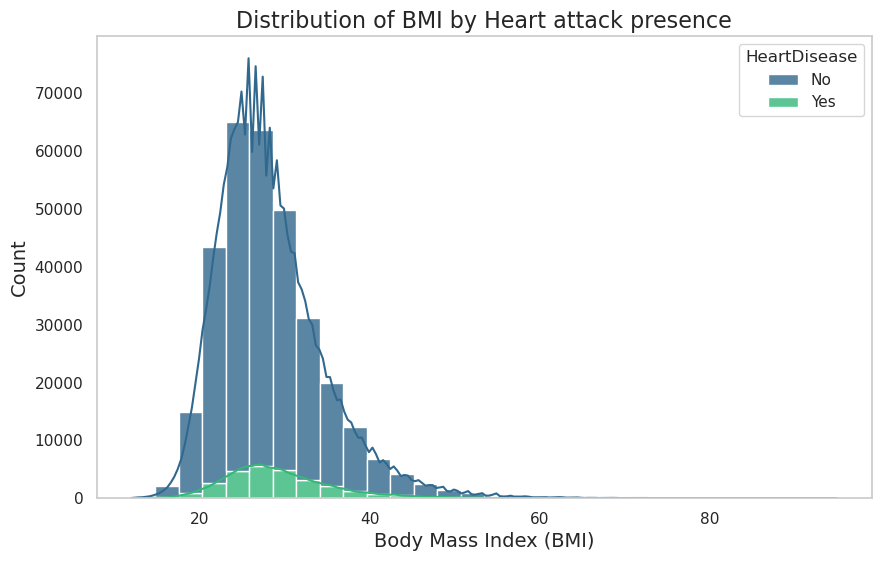

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.histplot(data=df, x='BMI', hue='HeartDisease', multiple='stack', kde=True, palette='viridis', bins=30, alpha=0.8, kde_kws={'bw_adjust': 0.5})

plt.title('Distribution of BMI by Heart attack presence', fontsize=16)
plt.xlabel('Body Mass Index (BMI)', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.grid(False)

plt.show()




We need to note that both classes follow, more or less, a normal distribution. There does not appear to be a clear pattern differentiating the target classes. However, it is true that the positive class exhibits a less pronounced peak.

Nevertheless, we can perform some numerical comparisons. We will compute all the metrics provided by the describe method for each target class and subtract the values for the positive class from those for the negative class to observe the differences.

In [8]:
positives_stats = df_positives.describe()
negatives_stats = df_negatives.describe()
difference_stats = positives_stats - negatives_stats

print(difference_stats['BMI']) 



count   -265049.000000
mean          1.176934
std           0.251491
min           0.190000
25%           1.170000
50%           1.080000
75%           1.370000
max         -11.520000
Name: BMI, dtype: float64


The difference in each of the attributes is minimal, so we can conclude that this feature does not exhibit any significant or trivial patterns that distinguish the two labels. However, it is real that in general people with heart diseases have a higher BMI value. Moreover, the difference between the means is the 4.131%, so both classes are definitely so close.

Now, we are going to analyze all the numerical features: PhysicalHealth, MentalHealth, and SleepTime.

However, a fundamental note should be made. We will use two different types of analysis:

    Comparing feature values among the positive class: This approach compares the values or categories of a feature between instances with  heart disease. This method is reliable if the distribution of values or categories is balanced across the dataset. If not, it can lead to misleading conclusions (an example of this will be demonstrated in the Race analysis). For continuous values, this approach is suitable because we can compute statistics like the mean.

    Comparing the presence of positive and negative instances for a specific value or category: This method avoids biases due to dataset imbalance and will be used for categorical data. 
    
For continuous values, we will use the first approach.

In [9]:
df.describe()['PhysicalHealth']

count    319795.00000
mean          3.37171
std           7.95085
min           0.00000
25%           0.00000
50%           0.00000
75%           2.00000
max          30.00000
Name: PhysicalHealth, dtype: float64

In difference with the BMI feature, this presents a higher dispersion. The standard deviation is about a 236 % of the average! From this not only follow the possibility of the presence of outliers, this can suggest that there is a clear difference between the two target classes. Let's see

In [10]:
print("Negatives statistics of Physical Health")
negatives_stats["PhysicalHealth"]

Negatives statistics of Physical Health


count    292422.000000
mean          2.956416
std           7.400378
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          30.000000
Name: PhysicalHealth, dtype: float64

In [11]:
print("Positive statistics of Physical Health")
positives_stats["PhysicalHealth"]

Positive statistics of Physical Health


count    27373.000000
mean         7.808242
std         11.487819
min          0.000000
25%          0.000000
50%          0.000000
75%         15.000000
max         30.000000
Name: PhysicalHealth, dtype: float64

Positive instances generally have a physical health score that is 2.64 times higher than that of negative instances. This indicates a significant difference. However, we need to introduce some nuance. If we take a closer look at the metrics, we can see that there are actually high values within the negative class. This suggests that negative instances can have high scores, but not the other way around, since the minimum score for the positive class is 0.

Regarding the percentile values, there is a significant difference in the 75th percentile. The value for PhysicalHealth in the positive class is 15 times higher than in the negative class, indicating that values in the positive class are generally larger. This pattern holds across the entire range of values, from the minimum to the maximum, within this class.

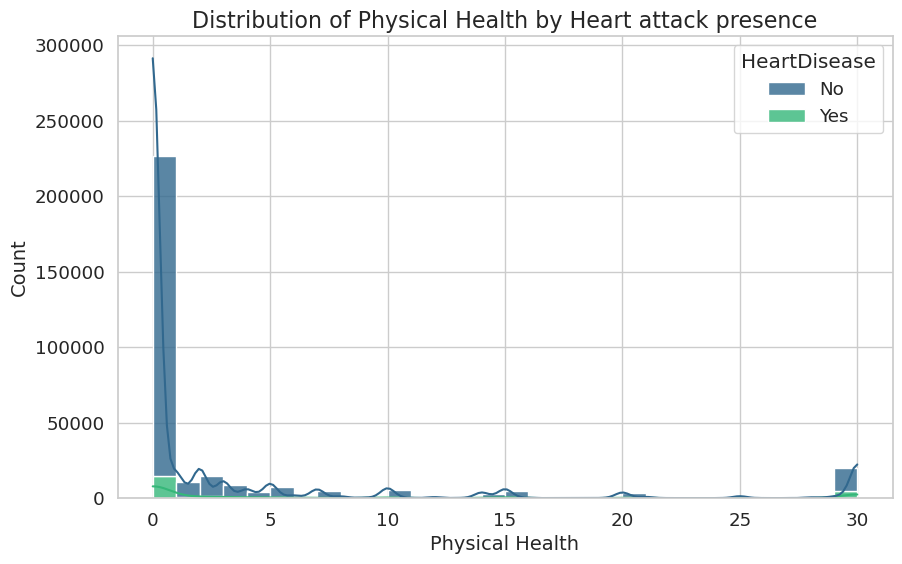

In [76]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='PhysicalHealth', hue='HeartDisease', multiple='stack', kde=True, palette='viridis', bins=30, alpha=0.8, kde_kws={'bw_adjust': 0.5})

plt.title('Distribution of Physical Health by Heart attack presence', fontsize=16)
plt.xlabel('Physical Health', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()


Now, it is clearer what we were explaining before. On the other hand, we found that the distribution of both classes does not seem to be normal this time.

For the Mental Health feature we will do the exact same steps that we did with the previous feature, so I will skip part of the explanations.


In [13]:
print("Negatives statistics of mental health")
negatives_stats["MentalHealth"]

Negatives statistics of mental health


count    292422.000000
mean          3.828778
std           7.828079
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          30.000000
Name: MentalHealth, dtype: float64

In [14]:
print("Positives statistics of Mental Health")
positives_stats["MentalHealth"]

Positives statistics of Mental Health


count    27373.000000
mean         4.641764
std          9.171932
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max         30.000000
Name: MentalHealth, dtype: float64

It's a similar situation to the PhysicalHealth analysis, however the differences are less meaningful. In this case, the ratio positives:negatives is about 1.2, and there are examples of instances in each class with the maximmum (30) and minimum (0) value. 

Another important characteristic is that values above 4 (the mean) are concentrated in the top 25%. A similar behavior can be observed in the previous feature, with comparable values, indicating that this pattern is present in both the positive and negative classes. From this, we can infer that while high MentalHealth scores are uncommon, they do not necessarily imply heart disease problems.

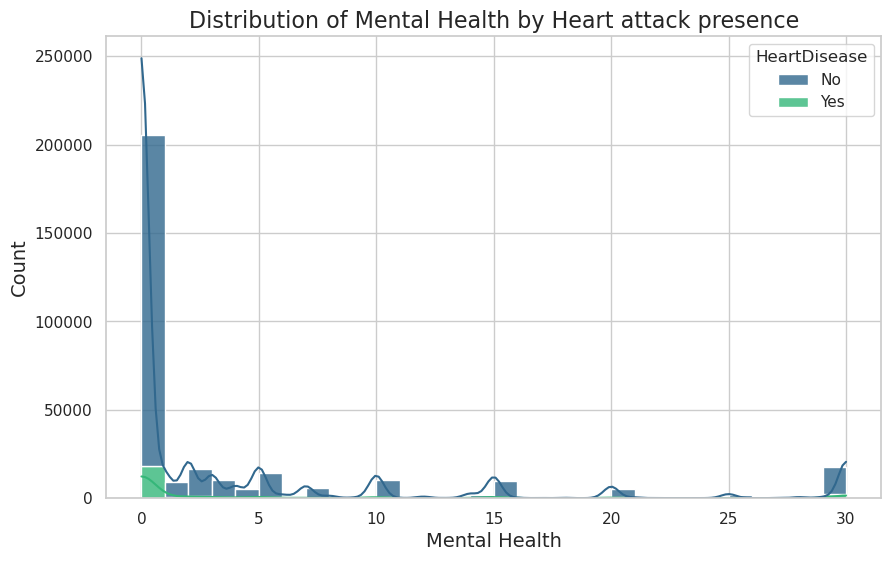

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='MentalHealth', hue='HeartDisease', multiple='stack', kde=True, palette='viridis', bins=30, alpha=0.8, kde_kws={'bw_adjust': 0.5})

plt.title('Distribution of Mental Health by Heart attack presence', fontsize=16)
plt.xlabel('Mental Health', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()

It's time for the last numerical value, the SleepTime feature. 

In [16]:
print("Negatives statistics of Sleep Time")
negatives_stats["SleepTime"]

Negatives statistics of Sleep Time


count    292422.000000
mean          7.093416
std           1.399331
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          24.000000
Name: SleepTime, dtype: float64

In [17]:
print("Positives statistics of Sleep Time")
positives_stats["SleepTime"]

Positives statistics of Sleep Time


count    27373.000000
mean         7.136156
std          1.780863
min          1.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         24.000000
Name: SleepTime, dtype: float64

This is suprising! Although the values are pretty pretty similar, the mean in the positive class is higher than the other, but the standard deviation is also higher, so this is not telling to us a lot of information.

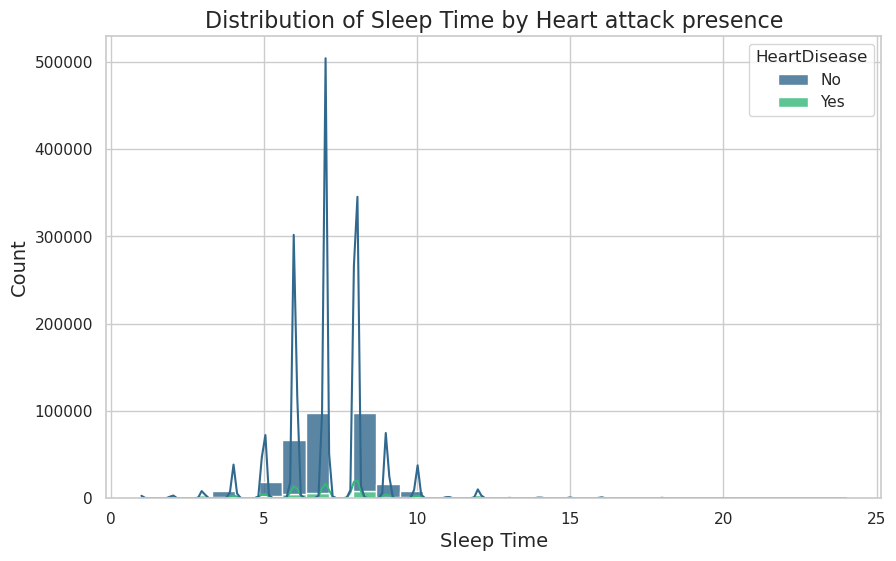

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='SleepTime', hue='HeartDisease', multiple='stack', kde=True, palette='viridis', bins=30, alpha=0.8, kde_kws={'bw_adjust': 0.5})

plt.title('Distribution of Sleep Time by Heart attack presence', fontsize=16)
plt.xlabel('Sleep Time', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()

Now, before going to other type of features, we will try to understand more deeply how the outliers behave in this previous features. We will use the boxplot graphs to gain an understanding of how the data is distributed, incorporating this information into our previous analysis.

In [19]:
np.array(df_positives['BMI']).max()

83.33

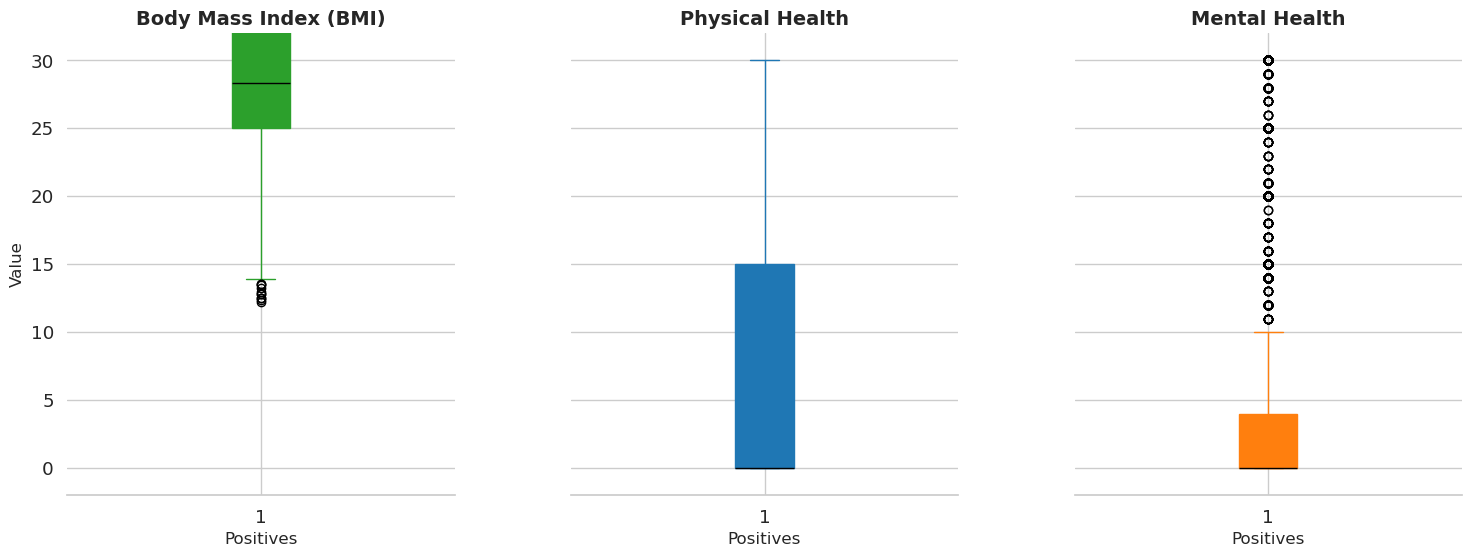

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

bmi_array = np.array(df_positives['BMI'])
phealth_array = np.array(df_positives['PhysicalHealth'])
mhealth_array = np.array(df_positives['MentalHealth'])

# Establece un estilo de gráfico moderno
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Crea la figura y los ejes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True, gridspec_kw={'wspace': 0.3})

# Colores personalizados
box_colors = ['#2ca02c', '#1f77b4', '#ff7f0e']

# Gráfico de Boxplot para BMI
axs[0].boxplot(bmi_array, patch_artist=True, boxprops=dict(facecolor=box_colors[0], color=box_colors[0]), 
               medianprops=dict(color='black'), whiskerprops=dict(color=box_colors[0]), capprops=dict(color=box_colors[0]))
axs[0].set_title('Body Mass Index (BMI)', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Positives', fontsize=12)
axs[0].set_ylabel('Value', fontsize=12)
axs[0].set_ylim([bmi_array.min() - 2, bmi_array.max() + 2])  # Ajusta el eje Y

# Gráfico de Boxplot para PhysicalHealth
axs[1].boxplot(phealth_array, patch_artist=True, boxprops=dict(facecolor=box_colors[1], color=box_colors[1]), 
               medianprops=dict(color='black'), whiskerprops=dict(color=box_colors[1]), capprops=dict(color=box_colors[1]))
axs[1].set_title('Physical Health', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Positives', fontsize=12)
axs[1].set_ylim([phealth_array.min() - 2, phealth_array.max() + 2])  # Ajusta el eje Y

# Gráfico de Boxplot para MentalHealth
axs[2].boxplot(mhealth_array, patch_artist=True, boxprops=dict(facecolor=box_colors[2], color=box_colors[2]), 
               medianprops=dict(color='black'), whiskerprops=dict(color=box_colors[2]), capprops=dict(color=box_colors[2]))
axs[2].set_title('Mental Health', fontsize=14, fontweight='bold')
axs[2].set_xlabel('Positives', fontsize=12)
axs[2].set_ylim([mhealth_array.min() - 2, mhealth_array.max() + 2])  # Ajusta el eje Y


# Ajusta el diseño y elimina el fondo
plt.subplots_adjust(wspace=0.3)

# Elimina los bordes superiores y derechos
sns.despine(left=True)
plt.show()


Okay! We are done with the most difficult features, and now we are going to dive into the categorical ones. For these, we will visualize different plots for each: showin different and useful proportions depending on the case

In the binary cases, we will compute the presence of each category in both the positive and negative classes. Instead of looking at the absolute percentages in each class, we will focus on the differences between them. Examining absolute percentages could introduce bias due to the imbalance in the dataset, so analyzing the differences provides a clearer view of the relationship between the categories and the target variable.

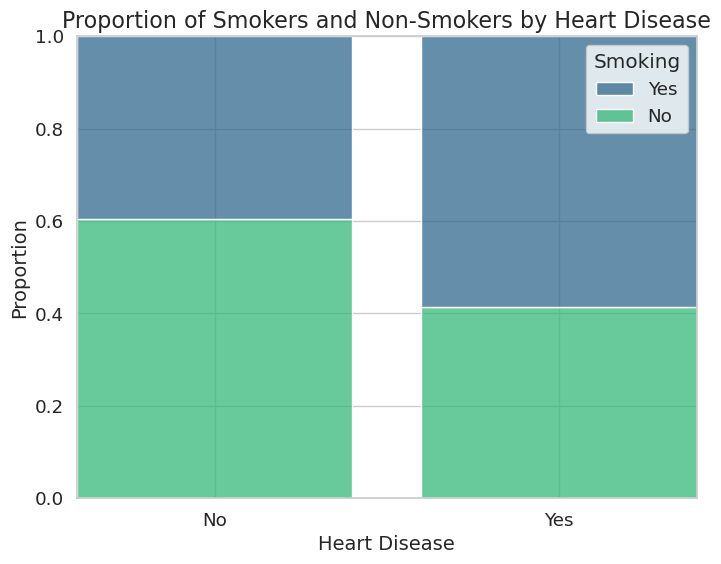

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd




plt.figure(figsize=(8, 6))

sns.histplot(data=df, x='HeartDisease', hue='Smoking', multiple='fill', shrink=0.8, palette='viridis')

plt.title('Proportion of Smokers and Non-Smokers by Heart Disease', fontsize=16)
plt.xlabel('Heart Disease', fontsize=14)
plt.ylabel('Proportion', fontsize=14)

plt.show()



In [22]:
smoking_negatives = df_negatives['Smoking'].value_counts().get('Yes', 0)
smoking_positives = df_positives['Smoking'].value_counts().get('Yes', 0)

In [23]:
print(f"The {int((100/len(df_negatives))*smoking_negatives)}% of the negatives instances present smoking activity\n")

print(f"The {int((100/len(df_positives))*smoking_positives)}% of the positives instances present smoking activity")

The 39% of the negatives instances present smoking activity

The 58% of the positives instances present smoking activity


This is a clear difference. We can technically say that the probability of a person with heart disease smoking is almost 60%, while in the other case, the value is lower, around 40%. This does not work the other way around. It wouldn’t make sense, since the number of negative instances is significantly larger than the positive ones. As a result, the proportion of people with heart disease who smoke, within the entire set of smokers, will be very small.

We can conclude that this is an important factor in the presence of heart disease.

Let's repeat this with the following categorical features

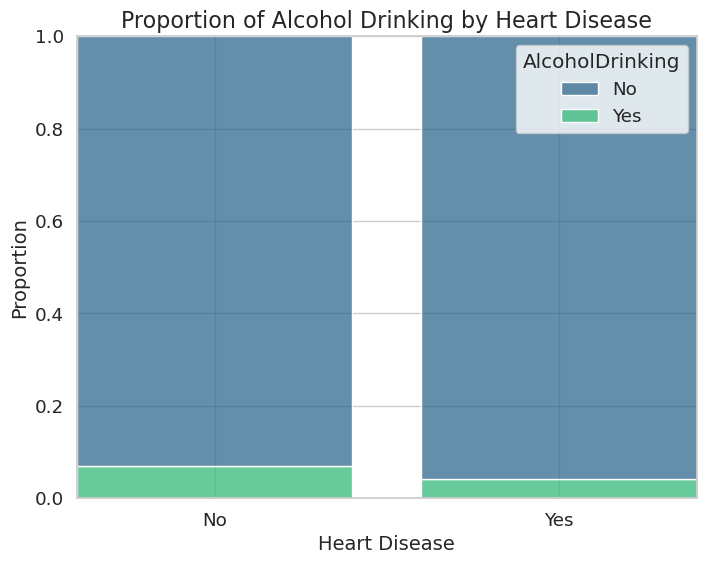

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd




plt.figure(figsize=(8, 6))

sns.histplot(data=df, x='HeartDisease', hue='AlcoholDrinking', multiple='fill', shrink=0.8, palette='viridis')

plt.title('Proportion of Alcohol Drinking by Heart Disease', fontsize=16)
plt.xlabel('Heart Disease', fontsize=14)
plt.ylabel('Proportion', fontsize=14)

plt.show()

The values are close (4% and 7%), we will not comment anything about them.

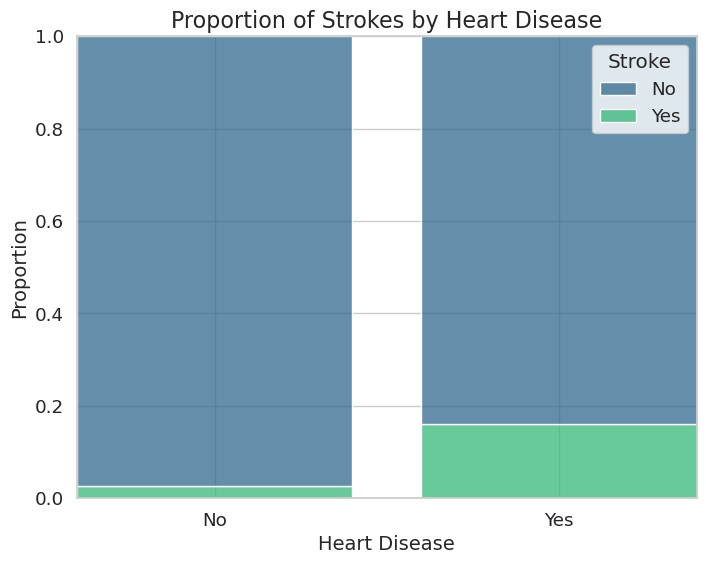

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd




plt.figure(figsize=(8, 6))

sns.histplot(data=df, x='HeartDisease', hue='Stroke', multiple='fill', shrink=0.8, palette='viridis')

plt.title('Proportion of Strokes by Heart Disease', fontsize=16)
plt.xlabel('Heart Disease', fontsize=14)
plt.ylabel('Proportion', fontsize=14)

plt.show()

With the same calculations, we can see that 2% of people without heart disease have had a stroke, while in the other group, this proportion rises to 16%. This is like the fourth power of the last value—what a huge difference!

We can repeat this process for the rest of the features, but it will be so tedious to show all the graphs. The proportions of the rest of binary categorical features are (I have to add diabetes during pregnacy):

| Feature              |  Positives  |  Negatives  |
|----------------------|:-----------:|:-----------:|
| **DiffWalking (Yes)** |     36%     |     11%     |
| **Female**            |     41%     |     53%     |
| **Male**              |     59%     |     47%     |
| **Prediabetes**       |    2.9%     |    2.1%     |
| **Diabetes**          |    32.7%    |    10.1%    |
| **Physical Act.**     |    63.9%    |    78.8%    |
| **Asthma**            |     18%     |     13%     |
| **Kidney Disease**    |    12.6%    |    2.84%    |
| **Skin Cancer**       |    18.2%    |    8.5%     |



In the majority of the features, there is a clear difference between the positive and negative instances. The most extreme case is in kidney disease, where the ratio is approximately 4.44. All of these categorical values will be encoded by associating one class with the integer 1 and the other with 0, avoiding the use of one-hot encoders.

For multicategorical features, we will plot horizontal bars representing the percentage of positive instances in each category. It is crucial not to confuse this with computing the percentage of each class within the positive instances. For example, if our dataset contains 1000 white individuals and 10 black individuals, and we look only at positive instances (those with a condition, such as heart disease), the percentage of black individuals among the positives might appear very low due to the imbalance in the number of individuals from each race. However, this does not imply that black individuals are less likely to have heart disease; it simply reflects the imbalance in the dataset.

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def percentage_categories(column_name):
    categories = df[column_name].unique().tolist()
    
    categories_values = df[df['HeartDisease'] == 'Yes'].groupby(column_name).size() / df.groupby(column_name).size()
    
    categories_values = categories_values.reindex(categories, fill_value=0)
    
    df_sorted = pd.DataFrame({
        column_name: categories_values.index,
        'Percentage': categories_values.values
    }).sort_values(by='Percentage')
    
    sorted_categories = df_sorted[column_name]
    sorted_values = df_sorted['Percentage']
    
    cmap = sns.color_palette("viridis", n_colors=len(sorted_categories))
    
    plt.barh(sorted_categories, sorted_values, color=cmap)
    
    for i, valor in enumerate(sorted_values):
        plt.text(valor + 0.02, i, f'{valor*100:.1f}%', va='center', color='black', fontsize=10)
    
    plt.xlabel('Percentage (%)', fontsize=12)
    plt.title('Percentage of Heart Disease per ' + column_name, fontsize=14)
    
    sns.despine(left=True, bottom=True)  
    plt.grid(axis='x', linestyle='--', alpha=0.6)  #
    
    plt.tight_layout()
    plt.show()


We will begin by examining the AgeCategory feature. Later, we will transform this feature into a numerical format to enable a variety of different approaches. For now, we will use it in its raw form.

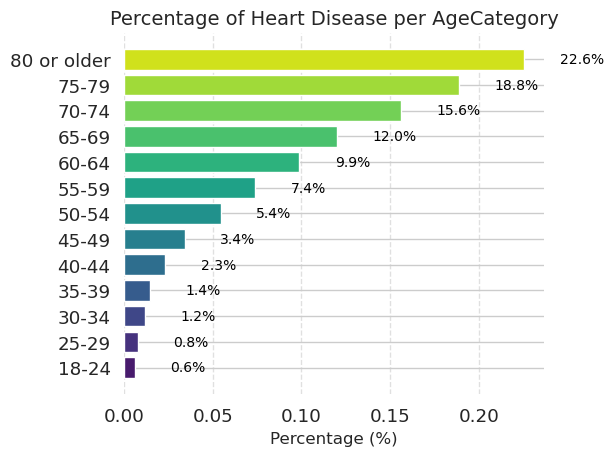

In [27]:
percentage_categories('AgeCategory')

Here's a polished version of your text formatted in Markdown:

There is a clear correlation between the increase in age categories and the percentage of heart disease within each category. This indicates that age is a crucial factor for determining the risk of having heart disease.

For those interested in a more mathematical perspective, consider the graph as a function where the Y-axis corresponds to age and the X-axis represents the percentage of heart disease. The relationship appears to resemble either a logarithmic function or perhaps an irrational function such as \(\sqrt{X}\).

If we wanted to model the risk as a function of age, we would need to compute the inverse function. For a logarithmic function, the inverse would be an exponential function, and for a \(\sqrt{X}\) function, the inverse would be \(X^2\). Thus, it is possible that the relationship between these features follows one of these functions.


Now, we are going to move on the Race feature.

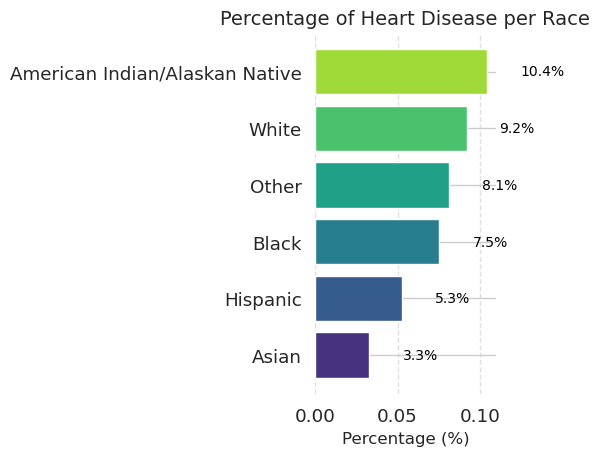

In [28]:
percentage_categories('Race')


It could be challenging to determine if these values come from a non-exhaustive dataset or if they genuinely reflect meaningful patterns. For instance, the higher incidence of heart disease among American Indians compared to Asians might be influenced by factors such as economic disparities or cultural differences in trust towards medical treatments. 

The underlying reasons are not always easy to uncover. However, it is crucial to trust the data (especially given its substantial size) and avoid being misled by personal biases or beliefs. 

The results reveal an arbitrary distribution, positioning Asians as having the least risk of heart disease, while Whites and American Indian/Alaskan Natives are at higher risk.

The trend appears to be more linear compared to the previous feature. If we imagine how the function of heart disease percentage by race might look, it could resemble a concave function such as \( \sqrt{x} \) or \( \ln(x) \). In this case, it doesn't make sense to try to discover a specific pattern because there is no possible mapping from races to numbers that preserves the "order."



Finally, the last feature to evaluate is Genetic Health (GenHealth).

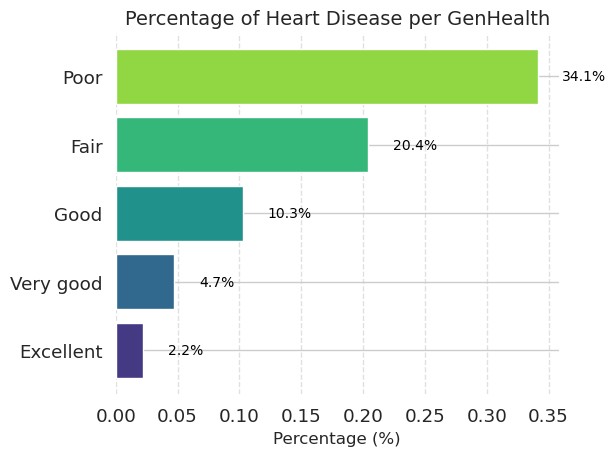

In [29]:
percentage_categories('GenHealth')

This feature clearly seems to have the most impact on the Heart Disease percentage at first glance, and the results confirm that belief. Between two consecutive categories, the percentage almost doubles, so the differences are substantial.


**Dimensionality reduction**

In this dataframe, we have 17 columns. Using one-hot encoding would expand this to around 30 features, resulting in a larger and more complex tensor. This increases the complexity of the model and may require it to learn more intricate patterns. Therefore, it's generally a good idea to remove unnecessary features that don't contribute to solving the problem. For example, if the dataset included a feature like 'Favourite Car,' it would likely have no relation to the target variable (heart disease) and could be safely excluded.

There are many algorithms designed to handle this task. Before applying any of them, we'll first examine the linear correlation between features. This metric, which ranges from -1 to 1, measures the linear relationship between two sets of values. To perform this analysis, we need to transform all values into a numerical format. We will focus on three types of features: numerical features, binary categorical features, and 'Age Category,' as it has a numerical meaning.

In [30]:
def category_to_number(s):
    if s == '80 or older':
        return 80
    age = (int(s[:2]) + int(s[3:]))/2
    return age

In [31]:
df_numerical = df[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']].copy()
df_numerical.loc[:, 'HeartDisease'] = df['HeartDisease'].replace({'Yes': 1, 'No': 0})
df_numerical.loc[:, 'Smoking'] = df['Smoking'].replace({'Yes': 1, 'No': 0})
df_numerical.loc[:, 'AlcoholDrinking'] = df['AlcoholDrinking'].replace({'Yes': 1, 'No': 0})
df_numerical.loc[:, 'Stroke'] = df['Stroke'].replace({'Yes': 1, 'No': 0})
df_numerical.loc[:, 'DiffWalking'] = df['DiffWalking'].replace({'Yes': 1, 'No': 0})
df_numerical.loc[:, 'Sex'] = df['Sex'].replace({'Female': 0, 'Male': 1})
df_numerical.loc[:, 'PhysicalActivity'] = df['PhysicalActivity'].replace({'No': 0, 'Yes': 1})
df_numerical.loc[:, 'Asthma'] = df['Asthma'].replace({'No': 0, 'Yes': 1})
df_numerical.loc[:, 'KidneyDisease'] = df['KidneyDisease'].replace({'No': 0, 'Yes': 1})
df_numerical.loc[:, 'Age'] = df['AgeCategory'].map(category_to_number)



/tmp/ipykernel_35744/919115310.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_numerical.loc[:, 'HeartDisease'] = df['HeartDisease'].replace({'Yes': 1, 'No': 0})
/tmp/ipykernel_35744/919115310.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_numerical.loc[:, 'Smoking'] = df['Smoking'].replace({'Yes': 1, 'No': 0})
/tmp/ipykernel_35744/919115310.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(c

In [32]:
corr = df_numerical.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='viridis', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,BMI,PhysicalHealth,MentalHealth,SleepTime,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,PhysicalActivity,Asthma,KidneyDisease,Age
BMI,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PhysicalHealth,0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
MentalHealth,0.06,0.29,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
SleepTime,-0.05,-0.06,-0.12,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
HeartDisease,0.05,0.17,0.03,0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Smoking,0.02,0.12,0.09,-0.03,0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan
AlcoholDrinking,-0.04,-0.02,0.05,-0.01,-0.03,0.11,nan,nan,nan,nan,nan,nan,nan,nan
Stroke,0.02,0.14,0.05,0.01,0.20,0.06,-0.02,nan,nan,nan,nan,nan,nan,nan
DiffWalking,0.18,0.43,0.15,-0.02,0.20,0.12,-0.04,0.17,nan,nan,nan,nan,nan,nan
Sex,0.03,-0.04,-0.10,-0.02,0.07,0.09,0.00,-0.00,-0.07,nan,nan,nan,nan,nan


The linear correlations observed do not show a strong relationship between most of the characteristics. However, a moderate correlation between DiffWalking and PhysicalHealth stands out, indicating that people with walking difficulties tend to have worse physical health conditions.

What can we do? If there is no linear relation between features, then the relationship might be non-linear—perhaps quadratic or even quintic. Relating variables using polynomials is a broad theme known as interpolation, which is not limited to polynomials. In this case, we will use different algorithms that fall under the concepts of 'projection' or 'manifold learning.'

**Preprocessing the data**

But before diving into this, we will quickly normalize the data. We will consider three initial cases for each feature. If it has a normal distribution with not too many outliers (a low standard deviation compared to the mean), we will apply the MinMaxScaler directly (which maps every instance to the range [0,1], improving algorithm performance). If we detect an exponential distribution that resembles a Russian Mountain, always decreasing very aggressively, we will use logarithmic normalization, followed by MinMaxScaler. Finally, if the distribution is roughly normal but with significant dispersion and outliers, we will first apply RobustScaler normalization, followed by MinMaxScaler again.

In [33]:
df_numerical.drop(columns=['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'HeartDisease'])

,BMI,PhysicalHealth,MentalHealth,SleepTime,Age
0,16.60,3.0,30.0,5.0,57.0
1,20.34,0.0,0.0,7.0,80.0
2,26.58,20.0,30.0,8.0,67.0
3,24.21,0.0,0.0,6.0,77.0
4,23.71,28.0,0.0,8.0,42.0
...,...,...,...,...,...
319790,27.41,7.0,0.0,6.0,62.0
319791,29.84,0.0,0.0,5.0,37.0
319792,24.24,0.0,0.0,6.0,47.0
319793,32.81,0.0,0.0,12.0,27.0


BMI and Sleep Time fall into the first case. Physical and Mental Health are a strange case because they are quite similar to an exponential distribution but have unexpected fluctuations at higher values. We could use Box-Cox scaling or more sophisticated tools, but we will follow the steps of the second case explained earlier to maintain simplicity. For Age, we need to observe its plot.

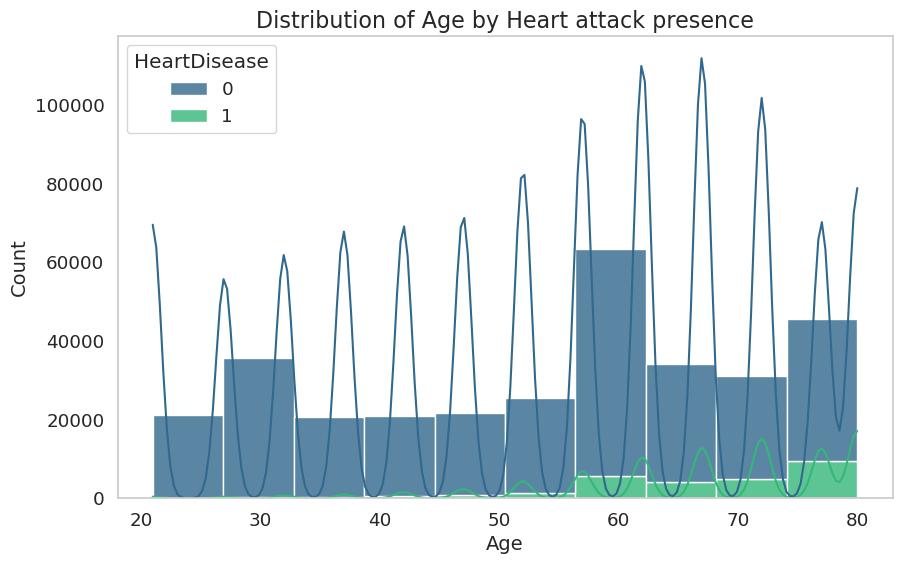

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.histplot(data=df_numerical, x='Age', hue='HeartDisease', multiple='stack', kde=True, palette='viridis', bins=10, alpha=0.8, kde_kws={'bw_adjust': 0.5})

plt.title('Distribution of Age by Heart attack presence', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.grid(False)

plt.show()

It is not a normal distribution, but it is somewhat close with several concessions. Let's observe the mean and standard deviation.

In [35]:
df_numerical.describe()['Age']

count    319795.000000
mean         54.355759
std          17.720429
min          21.000000
25%          42.000000
50%          57.000000
75%          67.000000
max          80.000000
Name: Age, dtype: float64

Okay, it does not have a high std in comparision with the std, so we will be using only the MinMaxScaler. I said that for binary categorical values we will use integers (0,1), but why I am not caring about this? The reason is that we will use a form of OneHot Encoding that uses n-1 coordinates for n classes (it assumes that if all values are 0 is the first class), so this will be made authomaticaly.

In [36]:
df['Age'] = df_numerical['Age']
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Age
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes,57.0
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No,80.0
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No,67.0
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes,77.0
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No,42.0


In [63]:
from sklearn.base import BaseEstimator, TransformerMixin

class Log(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.log1p(X)

In [64]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer



exponential_pipeline = Pipeline([
    ('log(1+x)', Log()),
    ('minmax', MinMaxScaler())
])


cat_encoder = OneHotEncoder(sparse_output=False, drop='first')

pipeline = ColumnTransformer([    
    ("hot", cat_encoder, ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']),
    ("exponential", exponential_pipeline, ['PhysicalHealth', 'MentalHealth']),
    ("minmax", MinMaxScaler(), ['BMI', 'SleepTime', 'Age'])
])



X = np.array(pipeline.fit_transform(df))
Y = np.where(df['HeartDisease'] == 'Yes', 1, 0)

**Reducing Dimensionality**

We have our desired tensor! This is fine, but the shape is (319795, 26), which is more than enormous. Can you imagine a space of 4th dimensions? Okay, now try it with 26. It is time for using the things I wrote previously about reducing dimensionality.

The PCA (Principal Component Analysis) tries to find a way of reducing the dimensionality by projecting onto a linear variety, such as a plane. It is NOT the same as what we did with the linear correlation examination, because that one was one-to-one, which only leads to lines.

As with all things, reducing dimensionality comes with a cost: losing "information." But, precisely, the trick is to do it in a way that this information loss is minimal.

Example: If we have the set {(1,2,3), (2,4,6)}, transforming it to {1,2} will not make us lose any information and will make the set smaller. But if the set is {(1,2,3), (2, 4.1, 5.6)}, doing the same will give us a smaller set, and you might think that the loss of information would be null, but that would not be the case, because these tiny variations in the ratios between the points might be MEANINGFUL.

With PCA, we can choose how much information (variance) we "want" to lose in the process, or we can choose how many final dimensions our result will have.

Let's try loosing a 10% of the variance

In [40]:
from sklearn.decomposition import PCA

pca_90 = PCA(n_components = 0.9)
X_reduced_90 = pca_90.fit_transform(X)
print(f'We lost the {100-100*np.sum(pca_90.explained_variance_ratio_):.2f}% of the information while retaining 90% of it')
np.shape(X_reduced_90)

We lost the 9.71% of the information while retaining 90% of it


(319795, 15)

Wow! That’s a significant improvement. We lost 9.7% of the variance but reduced the dimensionality by 28.6%. What if we want 10 dimensions? How much information will we lose in that case?

In [41]:
pca_10 = PCA(n_components = 10)
X_reduced_10 = pca_10.fit_transform(X)
print(f'We lost {100 - 100 * np.sum(pca_10.explained_variance_ratio_):.2f}% of the information while reducing the dimensions to 10.')


We lost 23.08% of the information while reducing the dimensions to 10.


Before diving deeper into this topic, let's plot a useful graph to understand the relationship between the loss of information and the new dimensions.

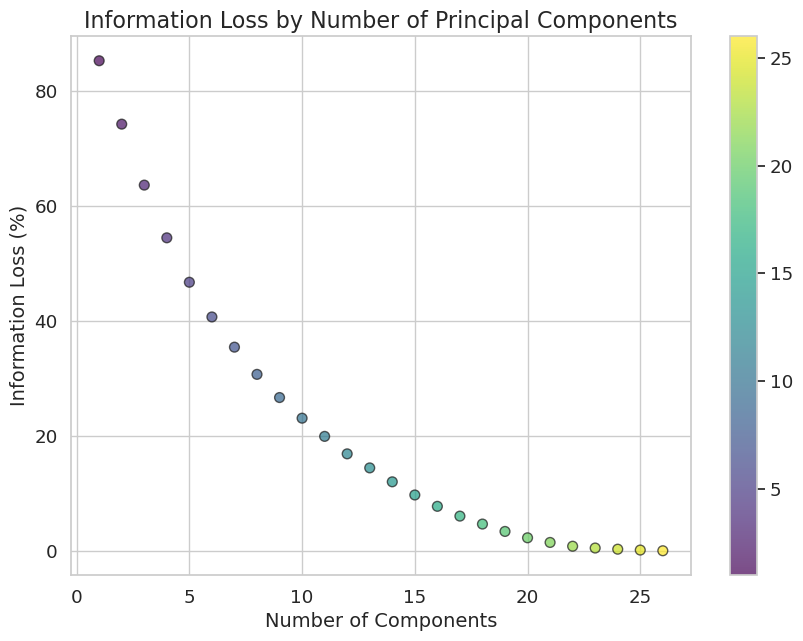

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA

X_points_pcas = np.arange(1, 27)
Y_points_pcas = np.zeros(26)

for k in range(1, 27):
    current_pca = PCA(n_components=k)
    current_reduction = current_pca.fit_transform(X)
    Y_points_pcas[k-1] = 100 - 100 * np.sum(current_pca.explained_variance_ratio_)

plt.figure(figsize=(10, 7))

cmap = matplotlib.colormaps['viridis']

scatter = plt.scatter(X_points_pcas, Y_points_pcas, c=X_points_pcas, cmap=cmap, s=50, alpha=0.7, edgecolor='k')

plt.colorbar(scatter)

plt.title('Information Loss by Number of Principal Components', fontsize=16)
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Information Loss (%)', fontsize=14)

# Mostrar el gráfico
plt.show()



Clearly, it would be impossible to train our model or draw any conclusions if we were to reduce the dimensionality to, for example, 2 dimensions. The loss of information is too significant, so that wouldn't help us. 

However, there is an advantage to using data with 2 or 3 coordinates beyond just having a more compact format. These reduced dimensions allow us to visualize the dataset in a 2D (X-Y) or 3D (X-Y-Z) space, which could be helpful for identifying patterns. However, this would still be challenging due to the loss of information.

We are going to plot how the instances look when we reduce them to 2 and 3 dimensions. We have to keep in mind that a lot of information will be lost, so not being able to separate the two classes in these cases does not mean it is impossible in the original dataset.

In [43]:
pca_2D = PCA(n_components = 2)
X_2D = pca_2D.fit_transform(X)
print(f'We lost the {100-100*np.sum(pca_2D.explained_variance_ratio_):.2f}% of the information while reducing the dimensions to 2')


We lost the 74.28% of the information while reducing the dimensions to 2


In [44]:
pca_3D = PCA(n_components = 3)
X_3D = pca_3D.fit_transform(X)
print(f'We lost the {100-100*np.sum(pca_3D.explained_variance_ratio_):.2f}% of the information while reducing the dimensions to 2')


We lost the 63.66% of the information while reducing the dimensions to 2


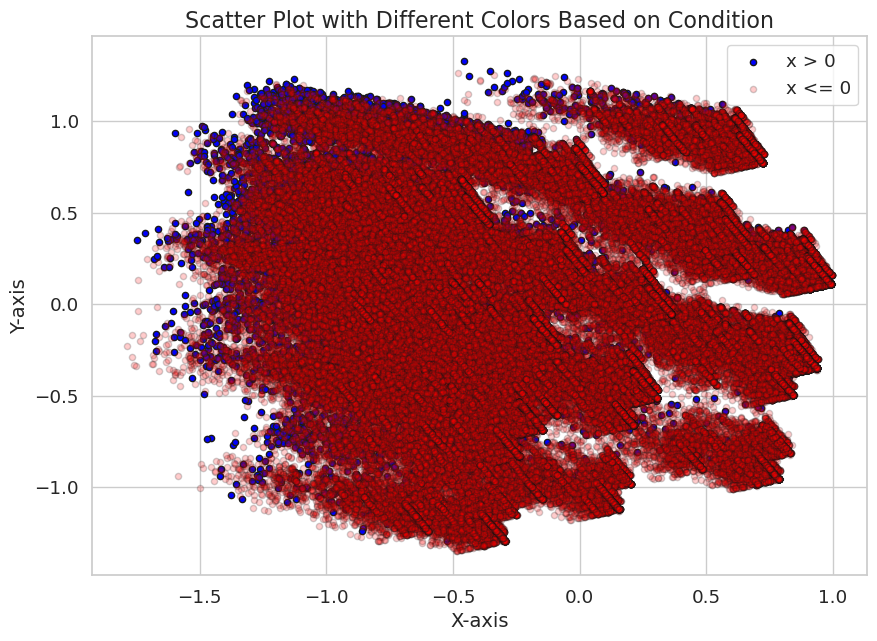

In [45]:
import numpy as np
import matplotlib.pyplot as plt

X_2D_Y = np.concatenate([X_2D, Y.reshape(-1, 1)], axis=1)

color_condition = (X_2D_Y[:, 2] == 1)

plt.figure(figsize=(10, 7))

plt.scatter(X_2D_Y[color_condition, 0], X_2D_Y[color_condition, 1], color='blue', label='x > 0', s=20, alpha=1, edgecolor='k')

plt.scatter(X_2D_Y[~color_condition, 0], X_2D_Y[~color_condition, 1], color='red', label='x <= 0', s=20, alpha=0.2, edgecolor='k')

plt.title('Scatter Plot with Different Colors Based on Condition', fontsize=16)
plt.xlabel('X-axis', fontsize=14)
plt.ylabel('Y-axis', fontsize=14)

plt.legend()

plt.show()





That's terrible. It's impossible to distinguish the blue points (positive class) from the red ones (negative class), and it's even more surprising when we realize that here, the opacity of the blue points is 5 times that of the red ones. So, the loss of information in this case makes the classification problem impossible.

Let's try with 3 dimensions

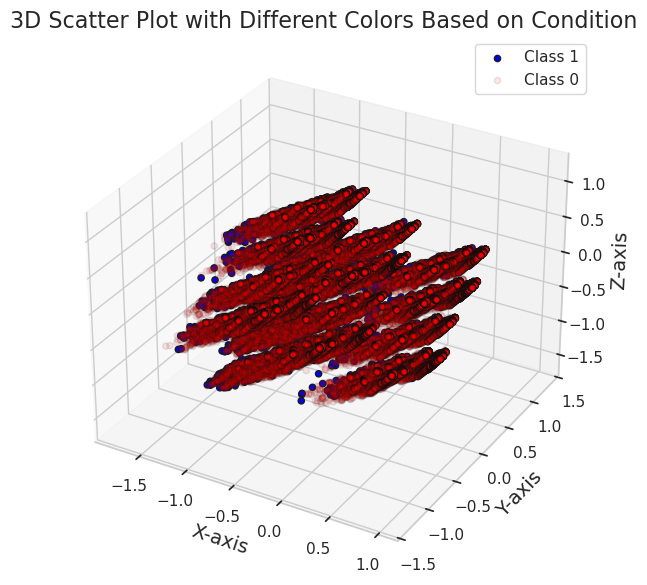

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X_3D_Y = np.concatenate([X_3D, Y.reshape(-1, 1)], axis=1)

color_condition = (X_3D_Y[:, 3] == 1)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_3D_Y[color_condition, 0], X_3D_Y[color_condition, 1], X_3D_Y[color_condition, 2], 
           color='blue', label='Class 1', s=20, alpha=1, edgecolor='k')

ax.scatter(X_3D_Y[~color_condition, 0], X_3D_Y[~color_condition, 1], X_3D_Y[~color_condition, 2], 
           color='red', label='Class 0', s=20, alpha=0.1, edgecolor='k')

ax.set_title('3D Scatter Plot with Different Colors Based on Condition', fontsize=16)
ax.set_xlabel('X-axis', fontsize=14)
ax.set_ylabel('Y-axis', fontsize=14)
ax.set_zlabel('Z-axis', fontsize=14)

plt.legend()
plt.show()


The same applies for this case.

There exists a version of PCA called KernelPCA that uses various transformations and sophisticated mathematical processes to uncover non-linear relationships. However, due to the size of the dataset, running these algorithms on my computer is infeasible, making it challenging to explore them further.